## Data Preprocessing

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Load the dataset
data = pd.read_csv('../data/patient_processed.csv')
# Select the relevant columns
features = data[['tanimoto', 'feature_jsim', 'feature_dsim', 'feature_osim']]
labels = data['DDI']

# Map DDI levels to the numeric values
ddi_mapping = {'no interaction found': 0, 'minor': 1, 'moderate': 2, 'major': 3}
labels = labels.map(ddi_mapping)

# Handle missing values
features = features.fillna(features.mean())

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.2, 
    random_state=42
)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the target variable to a categorical format
num_classes = len(ddi_mapping)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

## Define Hyperparameters

In [19]:
# Model Hypeparameters
num_features = len(ddi_mapping)
num_classes = X_train_scaled.shape[1]
learning_rate = 0.001
batch_size = 32
epochs = 100

# Privacy Hyperparameters
l2_norm_clip = 1.0
noise_multiplier = 1.1
num_microbatches = 1

## Build and Compile the Models

### Model Architecture

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer

def create_model(num_features, num_classes, noise_multiplier = 1.1, learning_rate = learning_rate):
    model = keras.Sequential([
        keras.layers.Input(shape=(num_features,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=learning_rate
        )
    
    model.compile(
        optimizer = optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Differential Privacy Model

#### Model Training

In [17]:
# Build a model with differential privacy
model_dp = create_model(num_features, num_classes)

# Use callbacks for early stopping and learning rate scheduling
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# Train the model
history = model_dp.fit(
    X_train_scaled, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
    callbacks =[early_stopping, lr_scheduler]
)

Epoch 1/100
5/5 [==============================] - 2s 71ms/step - loss: 1.3795 - accuracy: 0.4419 - val_loss: 1.3750 - val_accuracy: 0.3636 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 1.3769 - accuracy: 0.4574 - val_loss: 1.3698 - val_accuracy: 0.4848 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 1.3742 - accuracy: 0.5194 - val_loss: 1.3673 - val_accuracy: 0.4848 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 1.3713 - accuracy: 0.5349 - val_loss: 1.3631 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 1.3688 - accuracy: 0.5659 - val_loss: 1.3617 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - 0s 15ms/step - loss: 1.3678 - accuracy: 0.5736 - val_loss: 1.3618 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.3670 - a

#### Model Evaluation

In [35]:
# Evaluate the model
test_loss, test_accuracy = model_dp.evaluate(X_test_scaled, y_test_cat)
print(f"Test accuracy: {test_accuracy}")

2/2 [==============================] - 0s 5ms/step - loss: 1.0320 - accuracy: 0.8537
Test accuracy: 0.8536585569381714


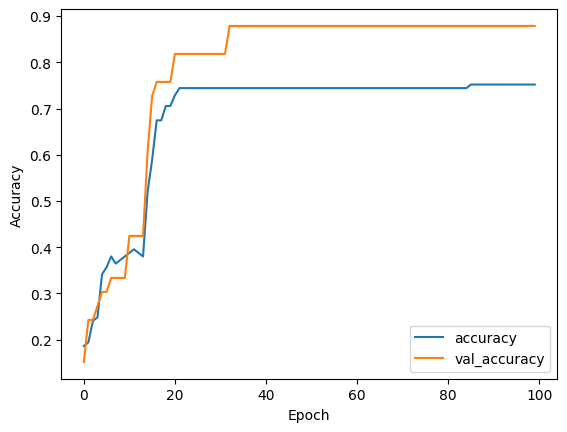

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Non-Differential Privacy Model

In [28]:
from keras.optimizers import SGD

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer_dp = DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

loss_dp = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

model_dp.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=loss_dp, metrics=['accuracy'])

# Train the DP model
model_dp.fit(X_train, y_train, epochs=10, validation_data=(X_train, y_train), batch_size=32)

NameError: name 'label_encoder' is not defined

### Saving Models

In [ ]:
model_dp.save('src/model')

### Evaluating Privacy

#### Evaluating Privacy Budget

In [37]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib

epsilon, alpha = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
    n=X_train.shape[0],
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    epochs=epochs,
    delta=1e-5
)

print(f"The privacy budget (epsilon) is: {epsilon}")

The privacy budget (epsilon) is: 34.40521375867571


#### Observing Privacy-Utility Tradeoff

In [38]:
noise_multipliers = [0.1, 0.5, 1.0, 2.0]
results = []

for noise_multiplier in noise_multipliers:
    
    print(f"\nTraining with noise multiplier: {noise_multiplier}")
    
    # Create the model
    model = create_model(num_features, num_classes, noise_multiplier)
    
    # Train the model
    history = model.fit(
        X_train_scaled, y_train_cat,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=0
    )
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
    
    # Calculate epsilon
    epsilon, _ = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
        n=len(X_train),
        batch_size=batch_size,
        noise_multiplier=noise_multiplier,
        epochs=epochs,
        delta=1e-5
    )
    
    results.append({
        'noise_multiplier': noise_multiplier,
        'test_accuracy': test_accuracy,
        'epsilon': epsilon
    })
    
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Epsilon: {epsilon:.4f}")
    
# Display results
for result in results:
    print(f"\nNoise Multiplier: {result['noise_multiplier']}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"Epsilon: {result['epsilon']:.4f}")


Training with noise multiplier: 0.1


Test accuracy: 0.8537
Epsilon: 27619.6354

Training with noise multiplier: 0.5


Test accuracy: 0.8537
Epsilon: 177.5309

Training with noise multiplier: 1.0


Test accuracy: 0.8293
Epsilon: 40.7370

Training with noise multiplier: 2.0


Test accuracy: 0.8537
Epsilon: 13.5931

Noise Multiplier: 0.1
Test Accuracy: 0.8537
Epsilon: 27619.6354

Noise Multiplier: 0.5
Test Accuracy: 0.8537
Epsilon: 177.5309

Noise Multiplier: 1.0
Test Accuracy: 0.8293
Epsilon: 40.7370

Noise Multiplier: 2.0
Test Accuracy: 0.8537
Epsilon: 13.5931


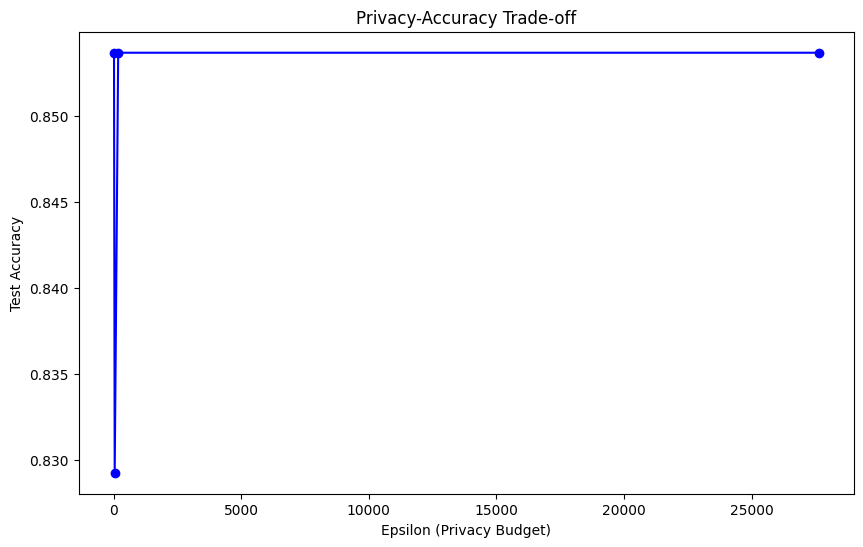

In [39]:
import matplotlib.pyplot as plt

epsilons = [result['epsilon'] for result in results]
accuracies = [result['test_accuracy'] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies, 'bo-')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Test Accuracy')
plt.title('Privacy-Accuracy Trade-off')
plt.show()

#### Define Callback for Privacy Metrics

In [40]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report

In [41]:
class PrivacyMetrics(tf.keras.callbacks.Callback):
  def __init__(self, epochs_per_report, model_name):
    self.epochs_per_report = epochs_per_report
    self.model_name = model_name
    self.attack_results = []

  def on_epoch_end(self, epoch, logs=None):
    epoch = epoch+1

    if epoch % self.epochs_per_report != 0:
      return

    print(f'\nRunning privacy report for epoch: {epoch}\n')

    logits_train = self.model.predict(x_train, batch_size=batch_size)
    logits_test = self.model.predict(x_test, batch_size=batch_size)

    prob_train = special.softmax(logits_train, axis=1)
    prob_test = special.softmax(logits_test, axis=1)

    # Add metadata to generate a privacy report.
    privacy_report_metadata = PrivacyReportMetadata(
        # Show the validation accuracy on the plot
        # It's what you send to train_accuracy that gets plotted.
        accuracy_train=logs['val_accuracy'], 
        accuracy_test=logs['val_accuracy'],
        epoch_num=epoch,
        model_variant_label=self.model_name)

    attack_results = mia.run_attacks(
        AttackInputData(
            labels_train=y_train_indices[:, 0],
            labels_test=y_test_indices[:, 0],
            probs_train=prob_train,
            probs_test=prob_test),
        SlicingSpec(entire_dataset=True, by_class=True),
        attack_types=(AttackType.THRESHOLD_ATTACK,
                      AttackType.LOGISTIC_REGRESSION),
        privacy_report_metadata=privacy_report_metadata)

    self.attack_results.append(attack_results)

#### Train Model and Collect Privacy Metrics

In [42]:
callback = PrivacyMetrics(epochs_per_report=2, model_name="DP Model")
history = model_dp.fit(
    X_train, 
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    batch_size=batch_size,
    callbacks=[callback],
    shuffle=True
)

Epoch 1/100


ValueError: in user code:

    File "c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 4) are incompatible


#### Visualise Privacy Metrics

In [ ]:
all_reports = callback.attack_results
results = AttackResultsCollection(all_reports)

##### Epoch Plots

In [ ]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(results, privacy_metrics=privacy_metrics)

##### Privacy VS Utility Plots

In [ ]:
utility_privacy_plot = privacy_report.plot_privacy_vs_accuracy(results, privacy_metrics=privacy_metrics)
for axis in utility_privacy_plot.axes:
    axis.set_xlabel('Validation accuracy')